<a href="https://colab.research.google.com/github/emgeiger/PlasticScanner/blob/main/PlasticScanner_Wavelength_Selection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf datasets
!rm -rf classes
!rm -rf resources
!git clone --depth 1 https://github.com/Plastic-Scanner/data
!mv data/data ./datasets
!rm -rf data
!git clone --depth 1 https://github.com/DataWorm/plastic-identifier.git
!mv plastic-identifier/classes ./
!mv plastic-identifier/resources ./
!rm -rf plastic-identifier

Cloning into 'data'...
remote: Enumerating objects: 1091, done.
remote: Counting objects: 100% (1091/1091), done.
remote: Compressing objects: 100% (1075/1075), done.
remote: Total 1091 (delta 16), reused 1058 (delta 14), pack-reused 0
Receiving objects: 100% (1091/1091), 38.32 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Cloning into 'plastic-identifier'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 5), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), 8.65 KiB | 2.16 MiB/s, done.


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from classes.AvantesDatasetLoader import AvantesDatasetLoader
from classes.SpectralonCalibrationTransformer import SpectralonCalibrationTransformer

In [ ]:
def extractFeatures(X : np.ndarray):
    # divides each feature by itself and all other features
    features = np.zeros(shape=(X.shape[0], X.shape[1]*X.shape[1]))
    for i in range(X.shape[1]):
        feature_column_transposed = np.reshape(X[:, i], (X.shape[0],1))
        #print(feature_column_transposed)
        with np.errstate(divide='ignore', invalid='ignore'):
            x = np.true_divide(X, feature_column_transposed)
            features[:, i*X.shape[1]:(i+1)*X.shape[1]] = np.nan_to_num(x)
    return features


def generateFeatureLabels(wavelengths : np.ndarray):
    labels = []
    for wavelength1 in wavelengths:
        for wavelength2 in wavelengths:
            labels.append('%s/%s' % (int(wavelength1), int(wavelength2)))
    return labels

def deviation(X : np.ndarray, mean : np.ndarray):
   #return np.mean(np.absolute(X-mean)**2, axis=0)
   return np.mean(np.absolute(X-mean), axis=0)

def project(X : np.ndarray):
    length = int(math.sqrt(X.shape[0]))
    projection = np.zeros(length)
    for i in range(length):
        for j in range(i+1, length):
            weight = X[i*length+j] + X[j*length+i]
            projection[i] += weight
            projection[j] += weight
    return projection

def project1(X : np.ndarray):
    length = int(math.sqrt(X.shape[0]))
    projection = np.zeros(length)
    for i in range(length):
        for j in range(i+1, length):
            weight = X[i*length+j]
            projection[i] += weight
    return projection

def project2(X : np.ndarray):
    length = int(math.sqrt(X.shape[0]))
    projection = np.zeros(length)
    for i in range(length):
        for j in range(i+1, length):
            weight = X[j*length+i]
            projection[j] += weight
    return projection

def project3(X : np.ndarray):
    length = int(math.sqrt(X.shape[0]))
    projection = np.zeros(length)
    for i in range(length):
        for j in range(i+1, length):
            weight = max(X[i*length+j], X[j*length+i])
            projection[i] += weight
            projection[j] += weight
    return projection


<ipython-input-4-a86b9295d767>:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  materials = pd.read_csv('resources/materials.csv', index_col='label', names=['label', 'materialNumber'], squeeze=True).to_dict()
<ipython-input-4-a86b9295d767>:27: RuntimeWarning: invalid value encountered in true_divide
  distances = var2 / var


PET:


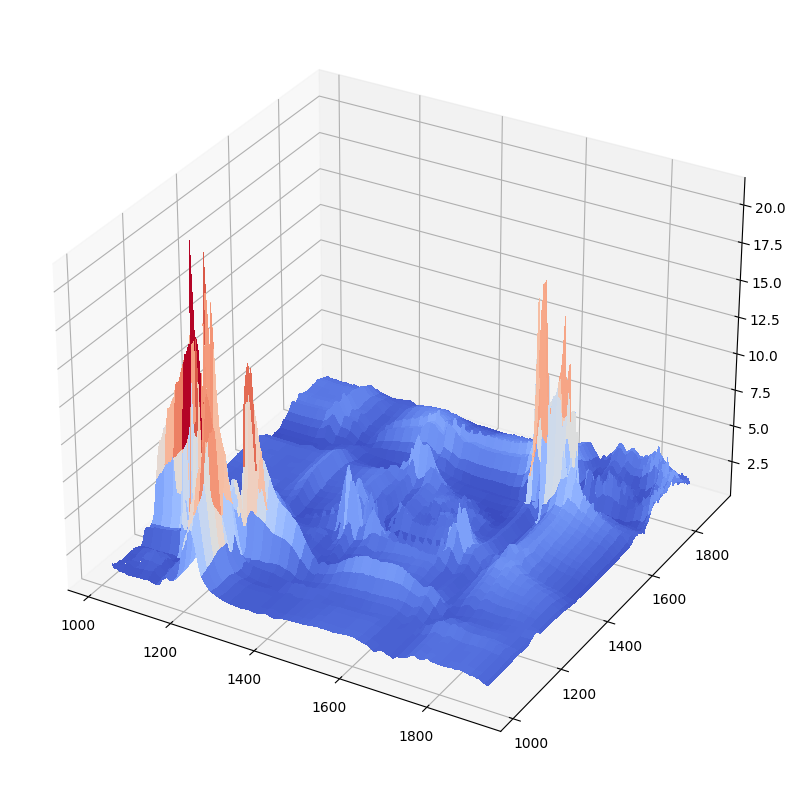

HDPE:


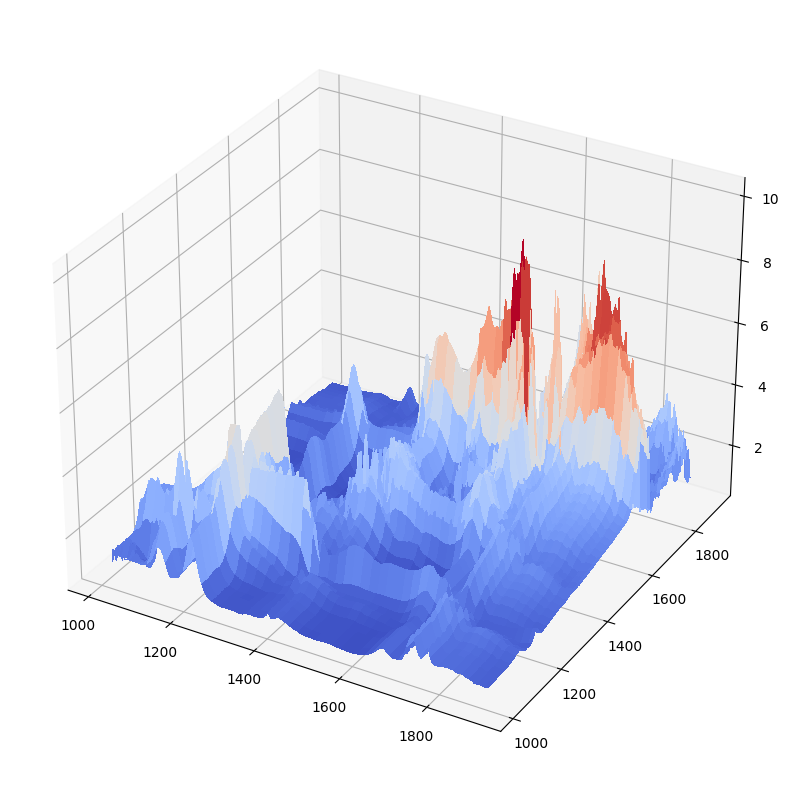

PVC:


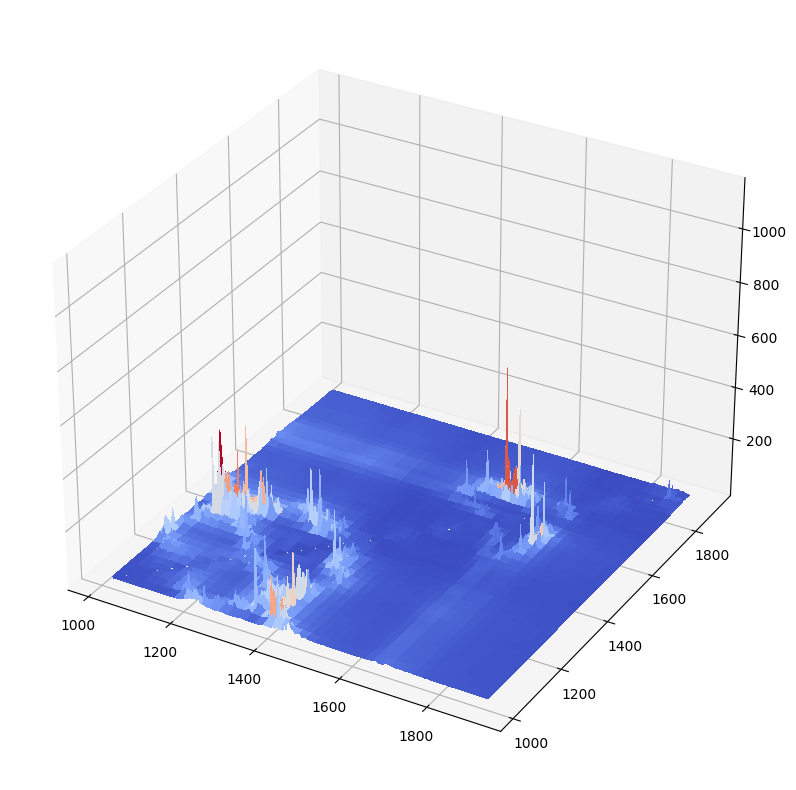

PP:


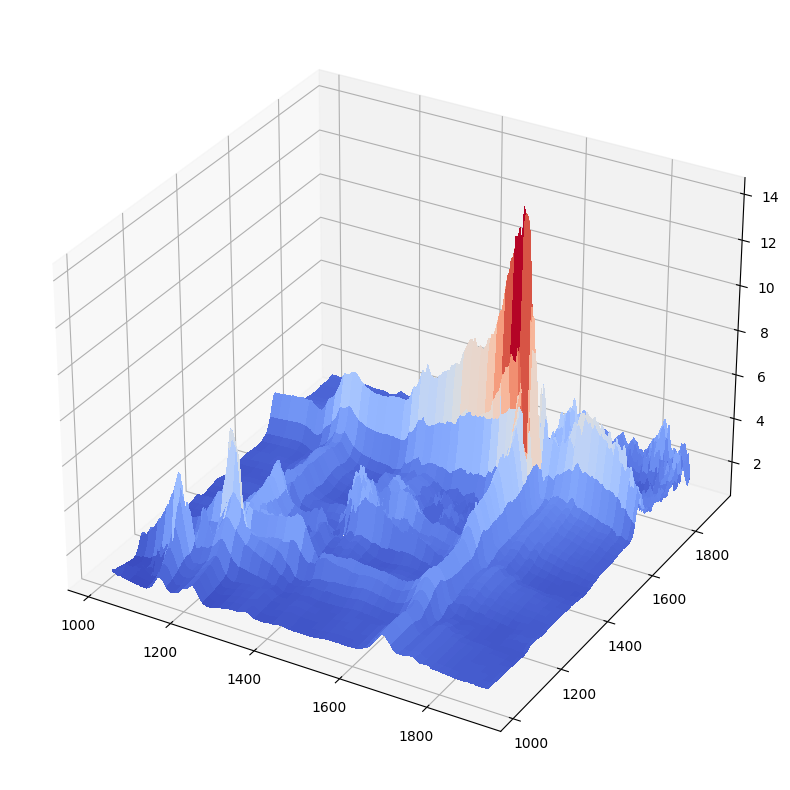

PS:


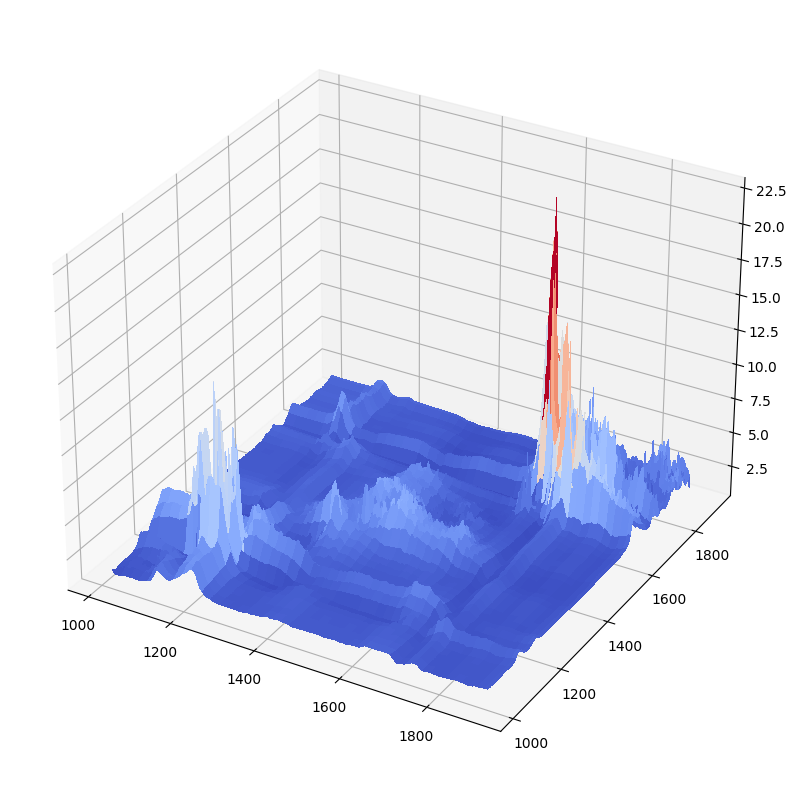

ABS:


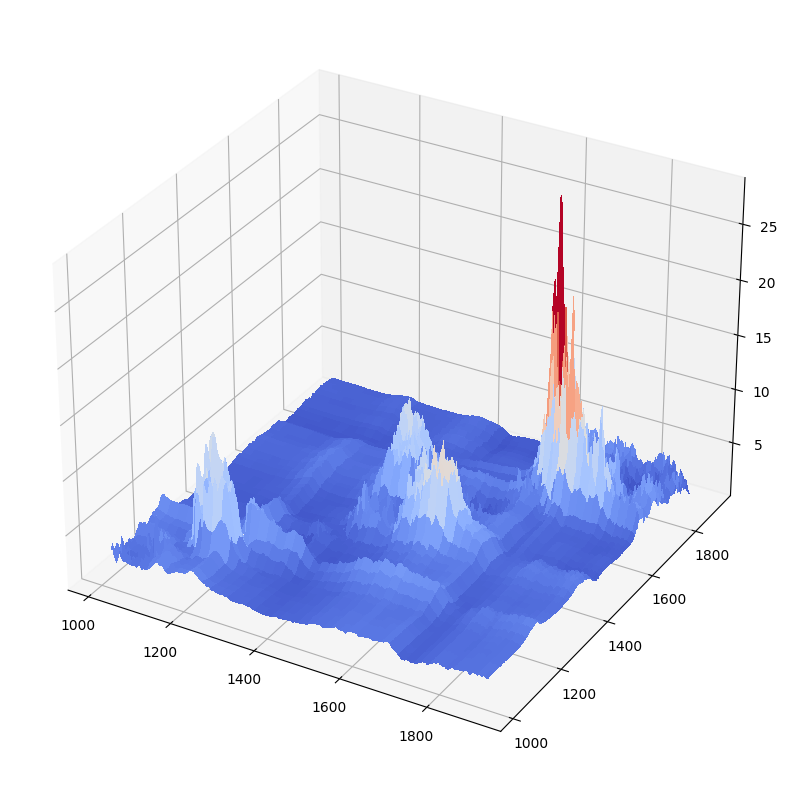

PLA:


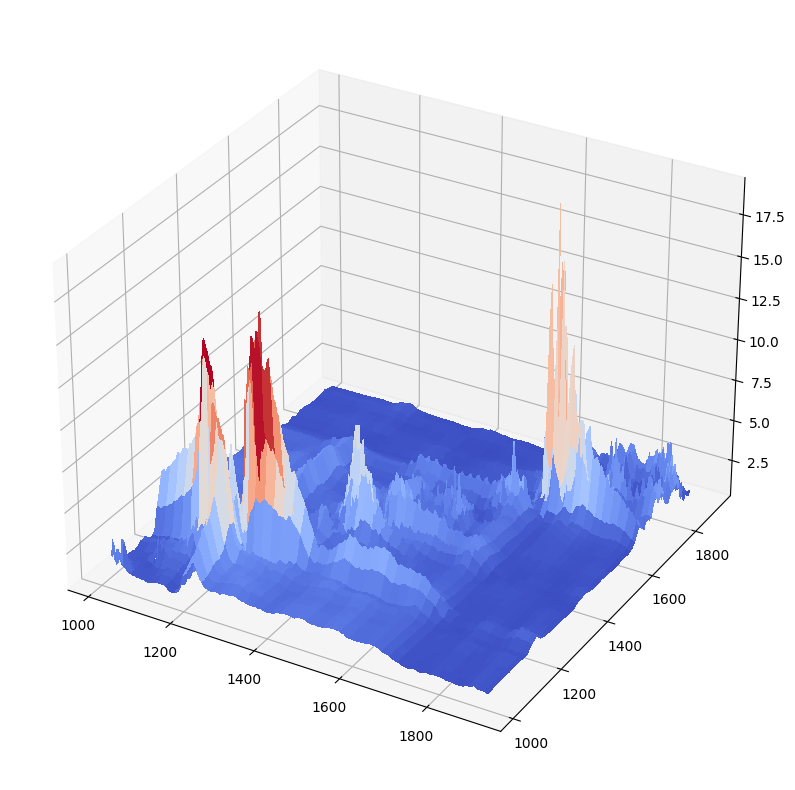

PC:


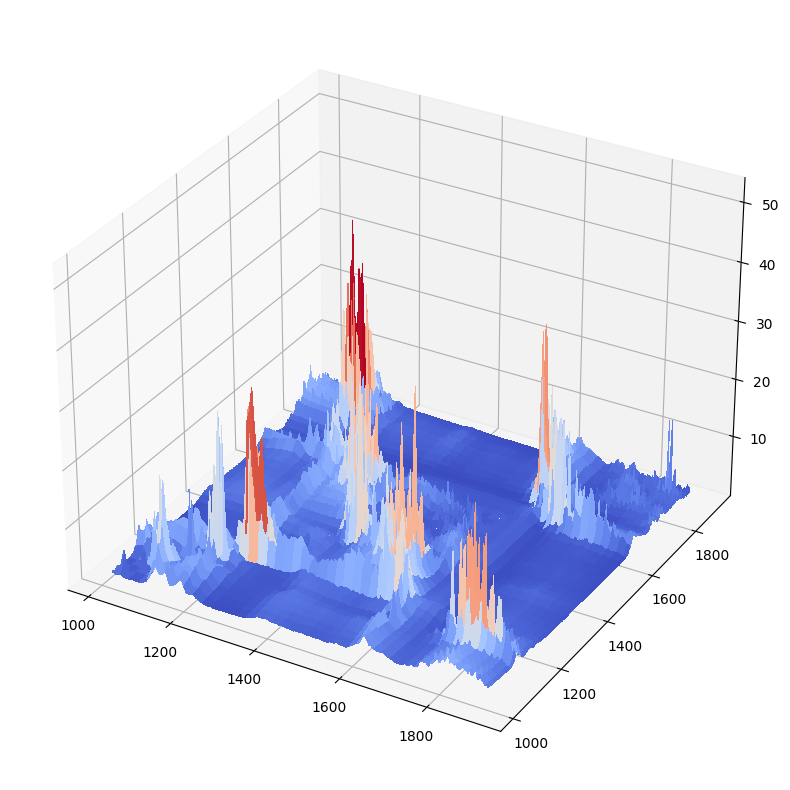

PMMA:


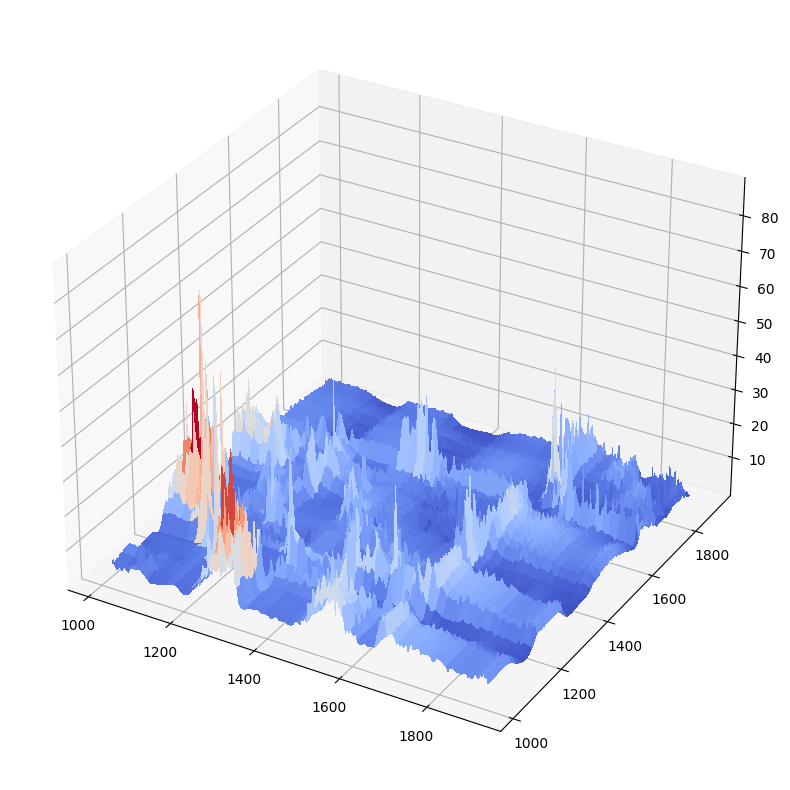

ASA:


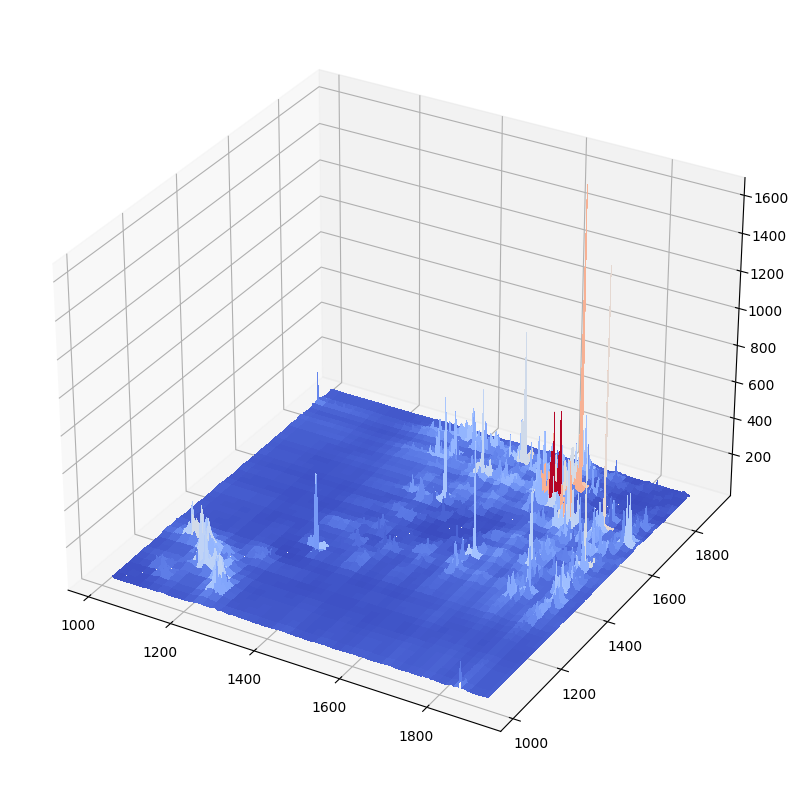

PACF:


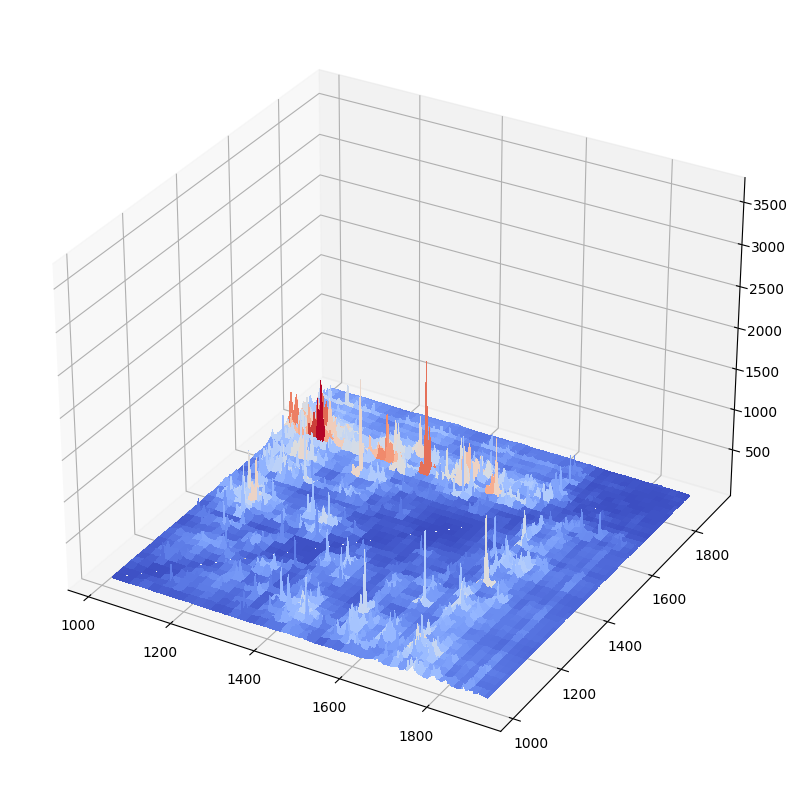

PCCF:


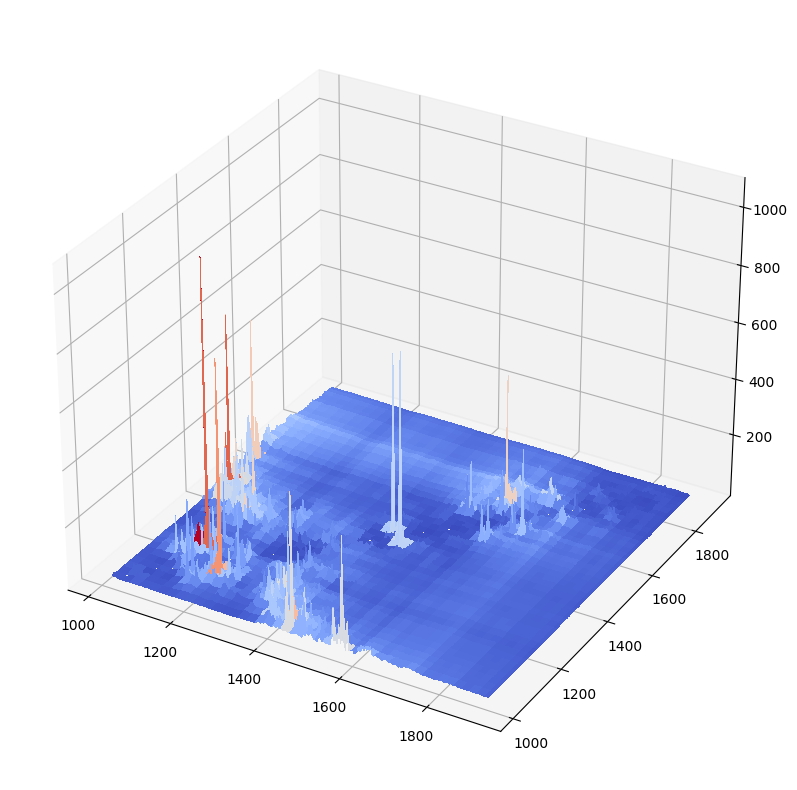

PETG:


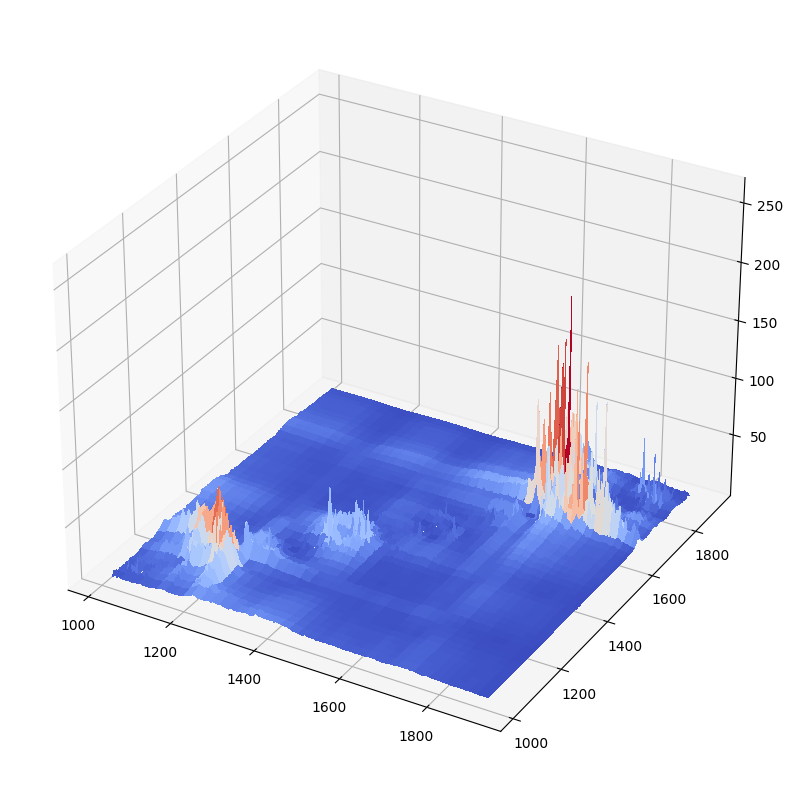

In [ ]:
0# Load list of materials to be considered for training and map them to numbers
materials = pd.read_csv('resources/materials.csv', index_col='label', names=['label', 'materialNumber'], squeeze=True).to_dict()
number_material_map = {v: k for k, v in materials.items()}

# Define which datasets shall be loaded for train and test data (if same dataset is used for train and test, data will be splitted)
dataset = AvantesDatasetLoader('datasets/20230419_avantes_spectrometer_fifth_dataset', materials).load()
#appender = DatasetAppenderTransformer(dataset)
#dataset = appender.transform(AvantesDatasetLoader('datasets/20221003_avantes_spectrometer/data', materials).load())
wavelengths = dataset.wavelengths

# Extract features from measurements
X = extractFeatures(dataset.X)
y = dataset.y
feature_labels = generateFeatureLabels(wavelengths)

projection_results = dict()
for materialLabel, materialNumber in materials.items():
    if not np.any(y == materialNumber):
        continue
    if materialLabel in ['Spectralon', 'spectralon']:
        continue

    mean = np.mean(X[y == materialNumber], axis=0)
    var = deviation(X[y == materialNumber], mean)

    var2 = deviation(X[y != materialNumber], mean) # build variance/deviation/distance using the mean of the current material instead of the whole dataset
    distances = var2 / var

    print(materialLabel + ':')

    plot_x, plot_y = np.meshgrid(wavelengths, wavelengths)
    plot_z = np.reshape(distances, (wavelengths.shape[0],wavelengths.shape[0]))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)
    surf = ax.plot_surface(plot_x, plot_y, plot_z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    plt.show()

    projection_results[materialLabel] = project3(distances);


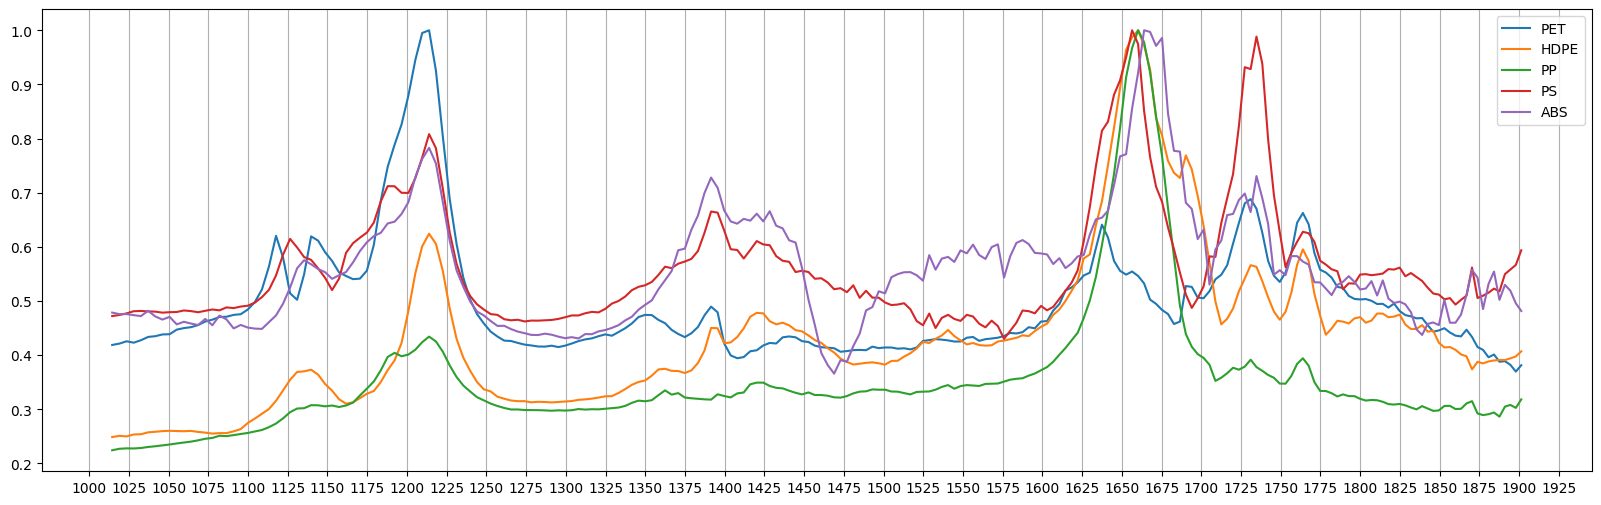

In [ ]:
plt.figure(figsize=(20,6))
plt.xticks(np.arange(round(min(wavelengths),-2), max(wavelengths)+25, 25))

for materialLabel, projection in projection_results.items():
    if np.count_nonzero(y == materials[materialLabel]) < 20 and materialLabel != 'ABS':
      continue
    normalized_projection = projection / max(projection)
    plt.plot(wavelengths, normalized_projection, label=materialLabel)
plt.grid(axis='x')
plt.legend()
plt.show()
